In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
train_data = TabularDataset(f'reformated3.csv')
train_data.head()

In [ ]:
label = 'SOC'
train_data[label].describe()

In [18]:
import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 30*60  # train various models for ~10 min
num_trials = 50  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor = TabularPredictor(label=label).fit(
    train_data, time_limit=time_limit, auto_stack=True,
    hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)

2023-03-26 17:08:30,889	ERROR tune.py:758 -- Trials did not complete: [3c440be9, 97a8fefb]
Fitted model: NeuralNetTorch_BAG_L1\17983e99 ...
	-2.6806	 = Validation score   (-root_mean_squared_error)
	35.61s	 = Training   runtime
	0.0s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 1007.57s of remaining time.
	-1.8885	 = Validation score   (-root_mean_squared_error)
	1.2s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 2 L2 models ...
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 452.82s of the 1006.18s of remaining time.
  0%|          | 0/50 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [19]:
test_data = TabularDataset(f'Data/Drive86_soc.csv')

y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

Loaded data from: Data/Drive86_soc.csv | Columns = 4 / 4 | Rows = 5617 -> 5617


0    60.480850
1    60.010952
2    60.010952
3    60.010952
4    60.010952
Name: SOC, dtype: float32

In [20]:

predictor.evaluate(test_data, silent=True)

c:\Users\kwitv\Documents\MARC\SOCprediction\venv\lib\site-packages\autogluon\tabular\predictor\predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -4.2926060549399,
 'mean_squared_error': -18.426466742906694,
 'mean_absolute_error': -3.3909229157069825,
 'r2': 0.899222225514653,
 'pearsonr': 0.9540055700818282,
 'median_absolute_error': -2.4783554067773466}

In [16]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch\4a6844c8,-3.062356,-2.517046,0.015960,0.031440,30.378147,0.015960,0.031440,30.378147,1,True,89
1,NeuralNetTorch\6364bf51,-3.334860,-2.282195,0.017952,0.032918,45.110435,0.017952,0.032918,45.110435,1,True,83
2,NeuralNetTorch\1d8cdd1c,-3.397763,-2.461853,0.023935,0.102243,129.299975,0.023935,0.102243,129.299975,1,True,53
3,NeuralNetTorch\b59b6091,-3.579241,-2.344439,0.043883,0.183570,56.546924,0.043883,0.183570,56.546924,1,True,88
4,NeuralNetTorch\d58a766f,-3.646890,-2.270650,0.018950,0.053867,53.881044,0.018950,0.053867,53.881044,1,True,54
...,...,...,...,...,...,...,...,...,...,...,...,...
88,LightGBM\T15,-20.303393,-13.505267,0.010970,0.006494,0.461818,0.010970,0.006494,0.461818,1,True,15
89,LightGBM\T4,-21.016262,-13.784838,0.007979,0.006981,0.327667,0.007979,0.006981,0.327667,1,True,4
90,LightGBM\T12,-22.140004,-14.785273,0.010971,0.004987,0.375054,0.010971,0.004987,0.375054,1,True,12
91,LightGBM\T29,-22.876166,-15.078863,0.007979,0.003989,0.414429,0.007979,0.003989,0.414429,1,True,29


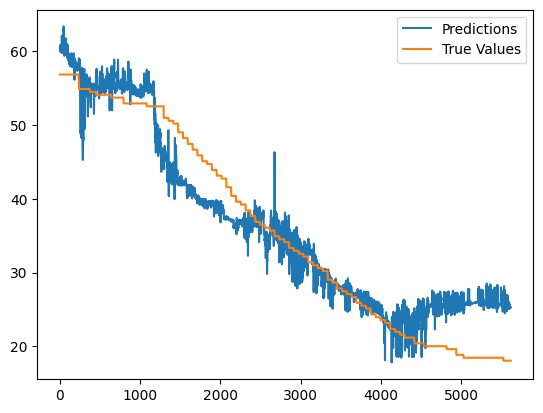

In [17]:
#plots the predicted vs actual values of the top performing model using matplotlib
import matplotlib.pyplot as plt
plt.plot(y_pred, label="Predictions")
plt.plot(test_data[label], label="True Values")
plt.legend()
plt.show()
